In [1]:
from IPython.core.display import HTML
css_file = '../../../../msc/custom.css' 
HTML(open(css_file, 'r').read()) 

# *grmpy* Package


Packages are a way to structure *Python* namespaces and help to orgainze our code in logical units. This allows makes our code more comprehensible and extensible.  

**Roadmap**

* Exploring the Package
* Exploring Performance
* Quality Assurance

## Exploring the Package


This is a first look at the structure of the *grmpy* package. 

Let us take a look at around the package in *PyCharm* in more detail. For example, we will study how to actually distribute a *Python* package across several files and folders. Throughout, we will encounter some very useful feature of our IDE that allow to navigate our *Python* package.


Before we get startedn using the package, let us import some basic libraries.

In [16]:
# Time access and conversions
import time

# Unix Pattern Extensions
import glob

# System-specific parameters and functions
import sys

# Operating System Interfaces
import os

# Plotting 
import matplotlib.pyplot as plt
%pylab inline --no-import-all

# Notebook Displays
from IPython.display import display, HTML 

# Importing the grmpy package by editing the PYTHONPATH 
sys.path.insert(0, 'grmpy')

# Package
import grmpy as gp

# Hidden function
from tests._auxiliary import random_init

Populating the interactive namespace from numpy and matplotlib


Now that we have an idea about the structure of the package, let us make some simple calls to the public functions. 

In [17]:
# Process initialization file
init_dict = gp.process('init.ini')

# Simulate synthetic sample
gp.simulate(init_dict)

# Estimate model
rslt = gp.estimate(init_dict)

# Write results
gp.inspect(rslt, init_dict)

# Inspect the results
%cat results.grm.txt


 softEcon: Generalized Roy Model
 -------------------------------

 Average Treatment Effects

     ATE       -0.39

     TT        -0.43

     TUT       -0.27


 Parameters

     Start    Finish

      0.50      0.50
      0.20      0.20
      0.52      0.52
      0.52      0.52
      0.10      0.10
      0.20      0.20
      0.30      0.30
      0.52      0.52
      0.12      0.12
      0.25      0.25
      0.35      0.35
      0.02      0.02
      0.02      0.02
      0.12      0.12
      0.10      0.10


From the perspective of the user, actually nothing changed compared to our implementation of a simple module. How do we get access to the relevant set of functions?

In [18]:
display(HTML('images/grmpy.html')) 

## Exploring Performance

There are several implementations of the likelihood function available: slow, fast, and object-oriented. We can select the implementation to use in the initialization file. Let us make sure that the result is the same regardless of the implementation. 

In [5]:
# Set the number of tests to run
NUM_TESTS = 1

# Run repeated tests
for _ in range(NUM_TESTS):

    # Generate random request
    init_dict = random_init()

    # Ensure same starting value. If we choose the random 
    # starting values instead, the points of evaluation 
    # differ for the slow and fast implementations.
    init_dict['ESTIMATION']['start'] = 'init'

    # Simulate sample
    gp.simulate(init_dict)
    
    # Initialize result container
    rslt = dict()
    
    # Estimate generalized Roy model
    for version in ['slow', 'fast', 'object']:

        init_dict['ESTIMATION']['version'] = version

        rslt[version] = gp.estimate(init_dict)['fval']

    # Assert equality of results
    np.testing.assert_allclose(rslt['slow'], rslt['fast'])
    np.testing.assert_allclose(rslt['slow'], rslt['object'])
    
    # Cleanup
    os.remove(init_dict['BASICS']['file'])

Let's see how the execution time differes as we increase the number of observations.

In [6]:
# Set grid for varying number of agents
agent_grid = range(1000, 10000, 500)

# Generate random request
init_dict = random_init()

# Request single function evaluation
init_dict['ESTIMATION']['maxiter'] = 0

# Simulate sample
rslt = dict()

for version in ['slow', 'fast', 'object']:
    
    # Initialzie container for results
    rslt[version] = []
    
    # Update initialization file
    init_dict['ESTIMATION']['version'] = version
    
    for agents in agent_grid:
        
        # Update initialization file
        init_dict['BASICS']['agents'] = agents
        
        # Simulate sample
        gp.simulate(init_dict)
        
        # Measure execution time of for estimation
        start_time = time.time()

        gp.estimate(init_dict)

        rslt[version] += [ time.time() - start_time]

Now we can easily visualize the difference in performance.

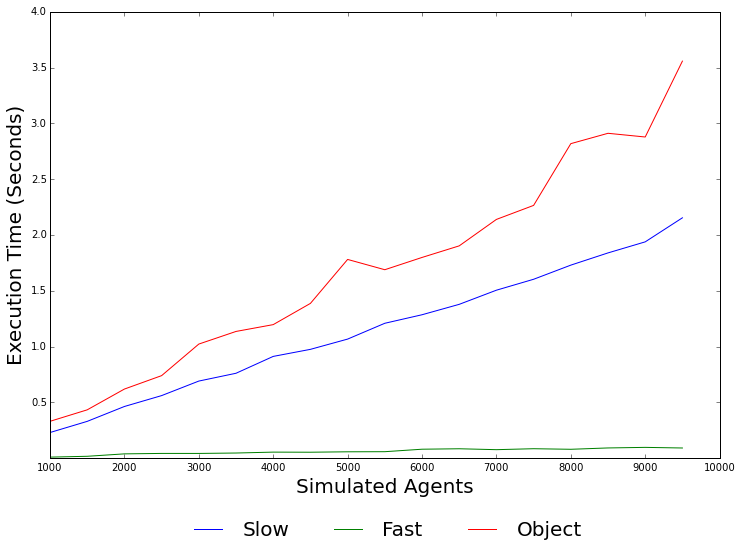

In [7]:
# Initialize canvas
ax = plt.figure(figsize=(12,8)).add_subplot(111)

# Plot execution times by implementations 
ax.plot(agent_grid, rslt['slow'], label='Slow')
ax.plot(agent_grid, rslt['fast'], label='Fast')
ax.plot(agent_grid, rslt['object'], label='Object')

# Set axis labels
ax.set_xlabel('Simulated Agents', fontsize=20)
ax.set_ylabel('Execution Time (Seconds)', fontsize=20)

# Set up legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
    fancybox=False, frameon=False, shadow=False, ncol=3,
    fontsize=20)
     
# Remove first element on y-axis
ax.yaxis.get_major_ticks()[0].set_visible(False)

What implementation choices are driving these differences in performance?

In [8]:
display(HTML('images/criterion.html')) 

*Profiling* tools allow to determine the performance of your computer program and identify the frequency and duration of function calls. Often just slight modifications make lead to more rapid executions and less memory use. More details about profiling *Python* code is available [here](https://docs.python.org/2/library/profile.html).

## Quality Assurance

Is our code working for all the different version of the model we want to be able to estimate? Often, parts of the code are only visited in special cases which results in errors remaining undetected for quite a while. Let us just hit the package with some random requests and see if it all runs. Later, of course, we will focus on whether it is actually working correctly.

In [9]:
# Set the number of tests to run
NUM_TESTS = 10

# Run repeated tests
for _ in range(NUM_TESTS):

    # Generate random request
    init_dict = random_init()
    
    # Let us restrict attention to either zero or just one 
    # step of the estimator.
    init_dict['ESTIMATION']['maxiter'] = np.random.choice([0, 1])
    
    # Simulate sample
    gp.simulate(init_dict)
    
    # Estimate model
    rslt = gp.estimate(init_dict)

    # Write results
    gp.inspect(rslt, init_dict)

Now, let us finally have a look whether the program actually recovers the true structural parameters.

In [19]:
# Generate random request
init_dict = random_init()

# Let us make sure to have a setup that is very favourable to
# the performance of our estimator for now. In my experience,
# small unobserved variability in agent choices and outcomes
# and a large agent count does the trick. Of course, later 
# you would want to investigate the performance of your 
# estimator for more challenging tasks.
for key_ in ['COST', 'TREATED', 'UNTREATED']:
    init_dict[key_]['var'] = 0.02

init_dict['BASICS']['agents'] = 10000

# We need to ensure that the random request actually entails
# a serious estimation run.
init_dict['ESTIMATION']['maxiter'] = 100
init_dict['ESTIMATION']['start'] = 'random'
init_dict['ESTIMATION']['version'] = 'fast'
init_dict['ESTIMATION']['optimizer'] = 'bfgs'
    
# Simulate synthetic sample
gp.simulate(init_dict)

# Estimate model
rslt = gp.estimate(init_dict)

# Check for convergence, which is very different from our 
# notion of a SUCCESSFUL estimation run. 
assert (rslt['success'] is True)

# Write results
gp.inspect(rslt, init_dict)

# Inspect the results
%cat results.grm.txt


 softEcon: Generalized Roy Model
 -------------------------------

 Average Treatment Effects

     ATE       -0.40

     TT        -0.73

     TUT        0.33


 Parameters

     Start    Finish

      0.82      0.42
      0.26     -0.32
      0.24     -0.15
      0.90      0.01
      0.50      0.40
      0.41      0.00
      0.40     -0.29
      0.94     -0.23
      0.03      0.02
      0.94      0.02
     -0.12      0.27
     -0.35      0.43


How does this compare to some of the structural parameters we used for the simulation of the dataset?

In [20]:
# Coefficients in the outcome equations
print '\nCoefficients for Outcome'
print max(rslt['TREATED']['all'] - init_dict['TREATED']['all'])
print max(rslt['UNTREATED']['all'] - init_dict['UNTREATED']['all'])

# Correlations
print '\nCorrelations'
print rslt['RHO']['treated'] - init_dict['RHO']['treated']
print rslt['RHO']['untreated'] - init_dict['RHO']['untreated']



Coefficients for Outcome
0.00321507281208
0.00272957549258

Correlations
-0.00903443515514
-0.00788631345176


Let us repeat this exercise, but use the Nelder Mead algorithm instead of BFGS. How does performance differ? What about using different starting values?

Let's investigate the performance of our estimator as we increase the variance in the choice equation. We will judge quality of the estimations by the Root-Mean-Squared Error (RMSE). 

In [12]:
def rmse(rslt):
    """ Calculate the root-mean squared error.
    """
    # Antibugging
    assert (isinstance(rslt, dict))

    # Distribute information
    x_internal = rslt['AUX']['x_internal']
    start_internal = rslt['AUX']['init_values']

    # Calculate statistic
    rslt = ((x_internal - start_internal) ** 2).mean()

    # Antibugging
    assert (np.isfinite(rslt))
    assert (rslt > 0.0)

    # Finishing
    return rslt

In [13]:
# Set grid for varying degree of noise
noise_grid = range(25)

init_dict = gp.process('init.ini')

# Simulate synthetic sample
rslt = dict()

for optimizer in ['bfgs', 'nm']:

    # Initialize containers
    rslt[optimizer] = []

    # Ensure same simulated setup
    np.random.seed(123)

    for i in noise_grid:

        # Increase noise in observed sample
        for key_ in ['COST', 'TREATED', 'UNTREATED']:
            init_dict[key_]['var'] = 0.01 + i*0.25
        
        # Simulate dataset
        gp.simulate(init_dict)

        # Select estimation setup
        init_dict['ESTIMATION']['version'] = 'fast'
        init_dict['ESTIMATION']['maxiter'] = 10000
        init_dict['ESTIMATION']['optimizer'] = optimizer
        init_dict['ESTIMATION']['start'] = 'random'

        # Calculate performance statistic
        stat = rmse(gp.estimate(init_dict))

        # Collect results
        rslt[optimizer] += [stat]


Let us visualize the performance.

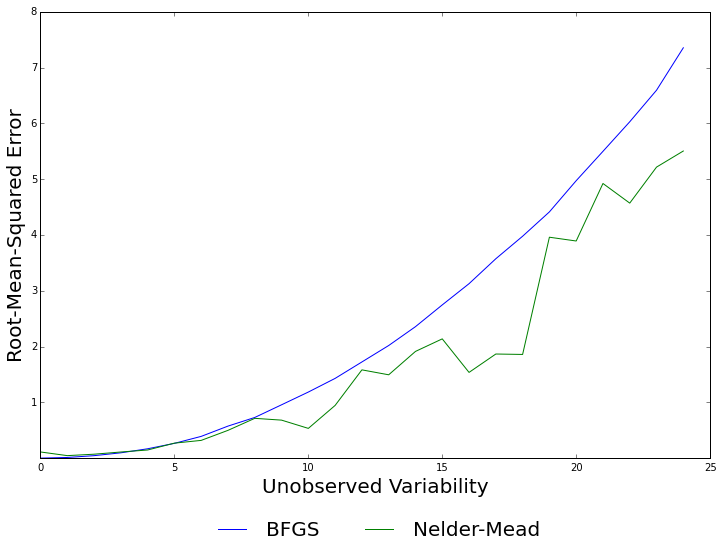

In [14]:
# Initialize canvas
ax = plt.figure(figsize=(12,8)).add_subplot(111)

# Plot execution times by implementations 
ax.plot(noise_grid, rslt['bfgs'], label='BFGS')
ax.plot(noise_grid, rslt['nm'], label='Nelder-Mead')

# Set axis labels
ax.set_xlabel('Unobserved Variability', fontsize=20)
ax.set_ylabel('Root-Mean-Squared Error', fontsize=20)

# Set up legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
    fancybox=False, frameon=False, shadow=False, ncol=2,
    fontsize=20)
     
# Remove first element on y-axis
ax.yaxis.get_major_ticks()[0].set_visible(False)

This concludes this lecture and all that remains done it to clean up.

In [15]:
# Create list of all files generated by the grmpy package
files = glob.glob('*.grm.*')

# Remove files
for file_ in files:
    
    os.remove(file_)